In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
# from sklearn.compose import make_column_transformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.metrics as metrics
from scikeras.wrappers import KerasClassifier
from sklearn.datasets import make_classification
import time
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import (classification_report, confusion_matrix, make_scorer, f1_score, recall_score, balanced_accuracy_score,
matthews_corrcoef, jaccard_score, average_precision_score, roc_auc_score)
from tabulate import tabulate
from sklearn.base import ClassifierMixin, BaseEstimator
import winsound
import random
import os
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

In [172]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X_nt = X_nt.drop(index = 83)
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [3]:
X_train = X_nt.copy()
y_train = y_nt.copy()
X_test = X_t.copy()
y_test = y_t.copy()

In [11]:
# Create a DataFrame with random indices
data = {'A': [1, 2, 3, 4, 5], 'B': [6, 7, 8, 9, 10], 'C': [11, 12, 13, 14, 15], 'D': [16, 17, 18, 19, 20]}
df = pd.DataFrame(data, index=np.random.permutation(100)[:5])  # Random indices from 0 to 99

In [12]:
print("Original DataFrame:")
print(df)

Original DataFrame:
    A   B   C   D
55  1   6  11  16
15  2   7  12  17
57  3   8  13  18
16  4   9  14  19
23  5  10  15  20


In [15]:
df = df.reset_index(drop = True)

In [18]:
X_train['y_train'] = y_train
X_test['y_test'] = y_test
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [19]:
y_train = X_train.pop('y_train')
y_test = X_test.pop('y_test')

In [22]:
drop_onehot = ['SEX_F', 'SITE_BL', 'HISTOPATHOLOGY_PAP', 'APPROACH_3']
X_train = X_train.drop(columns = drop_onehot)
X_test = X_test.drop(columns = drop_onehot)

In [37]:
def preprocessor(X_train, X_test, X_val = None):
    imputer = SimpleImputer(strategy = 'median')
    scaler = StandardScaler()
    X_train_pp = scaler.fit_transform(imputer.fit_transform(X_train))
    X_test_pp = scaler.transform(imputer.transform(X_test))
    if X_val is not None:
        X_val_pp = scaler.transform(imputer.transform(X_val))
        return X_train_pp, X_test_pp, X_val_pp
    else:
        return X_train_pp, X_test_pp

In [23]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)
kf = KFold(n_splits=n_splits)

In [235]:
def create_model():
    model = Sequential([
        Dense(100, input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(100, kernel_regularizer=l2(0.01)), # activation='elu'), #),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(100, kernel_regularizer=l2(0.01)), # activation='elu'), #kernel_regularizer=l2(0.01)),
        LeakyReLU(0.2),
        Dropout(0.3),
        Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
    ])
    model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]}
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [236]:
f1_scores_df = pd.DataFrame(columns=['Fold', 'Train F1 Score', 'Validation F1 Score', 'Test F1 Score', 'Train AUC-PR', 'Val AUC-PR', 'Test AUC-PR'])
history_dict = {}

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    print(f'Fold {fold + 1}/{n_splits}')
    # print(train_index)
    # # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # print(sum(y_train_fold)/len(y_train_fold), sum(y_val_fold)/len(y_val_fold), sum(y_test)/len(y_test))
    
    X_train_fold_pp, X_test_fold_pp, X_val_fold_pp = preprocessor(X_train_fold, X_test, X_val_fold)
    
    # print(len(X_train_fold_pp), len(X_val_fold_pp), len(y_train_fold), len(y_val_fold))
    # Create and train the model
    model = create_model()
    history = model.fit(X_train_fold_pp, y_train_fold, epochs=200, batch_size=32, validation_data=(X_val_fold_pp, y_val_fold),
                        callbacks = [early_stopping, reduce_lr], class_weight=class_weight)

    # Evaluate the model on the validation set
    loss, accuracy = model.evaluate(X_val_fold_pp, y_val_fold)
    print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')
    
    predictions_train = model.predict(X_train_fold_pp)
    threshold = 0.5  # Adjust the threshold as needed
    predicted_labels = (predictions_train > threshold).astype(int)
    train_f1_score = f1_score(y_train_fold, predicted_labels)
    # print("f1 score: ", train_f1_score)
    # print(predicted_labels.reshape((-1)))
    train_auc_pr = average_precision_score(y_train_fold, predicted_labels)
    # print("AUC-PR:", train_auc_pr)
    cm = confusion_matrix(y_train_fold, predicted_labels)
    class_names = ['Class 0', 'Class 1']
    cm_table_train = tabulate(cm, headers=class_names, tablefmt='grid')
    print("Confusion Matrix:")
    print(cm_table_train)
    
    predictions_val = model.predict(X_val_fold_pp)
    predicted_labels = (predictions_val > threshold).astype(int)
    val_f1_score = f1_score(y_val_fold, predicted_labels)
    # print("f1 score: ", val_f1_score)
    # print(predicted_labels.reshape((-1)))
    val_auc_pr = average_precision_score(y_val_fold, predicted_labels)
    cm = confusion_matrix(y_val_fold, predicted_labels)
    cm_table_val = tabulate(cm, headers=class_names, tablefmt='grid')
    print("Confusion Matrix:")
    print(cm_table_val)
    
    predictions = model.predict(X_test_fold_pp)
    predicted_labels = (predictions > threshold).astype(int)
    test_f1_score = f1_score(y_test, predicted_labels)
    print("f1 score: ", test_f1_score)
    # print(predicted_labels.reshape((-1)))
    test_auc_pr = average_precision_score(y_test, predicted_labels)
    cm = confusion_matrix(y_test, predicted_labels)
    cm_table_test = tabulate(cm, headers=class_names, tablefmt='grid')
    print("Confusion Matrix:")
    print(cm_table_test)

    f1_scores_df = pd.concat([f1_scores_df, pd.DataFrame({'Fold': [fold + 1],
                                                          'Train F1 Score': [train_f1_score],
                                                          'Validation F1 Score': [val_f1_score],
                                                          'Test F1 Score': [test_f1_score],
                                                          'Train AUC-PR': [train_auc_pr],
                                                          'Val AUC-PR': [val_auc_pr],
                                                          'Test AUC-PR': [test_auc_pr]})], ignore_index=True)
    history_dict[fold] = history

Fold 1/5
Epoch 1/200
13/13 [==============================] - 4s 59ms/step - loss: 3.0127 - accuracy: 0.6253 - val_loss: 2.8156 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 13ms/step - loss: 2.7875 - accuracy: 0.6977 - val_loss: 2.6076 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 2.5568 - accuracy: 0.6589 - val_loss: 2.4300 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 13ms/step - loss: 2.3708 - accuracy: 0.7235 - val_loss: 2.2546 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 2.2040 - accuracy: 0.7054 - val_loss: 2.1161 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 13ms/step - loss: 2.0516 - accuracy: 0.7339 - val_loss: 1.9469 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 13ms/

C:\Users\aniru\AppData\Local\Temp\ipykernel_33108\1700032539.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_scores_df = pd.concat([f1_scores_df, pd.DataFrame({'Fold': [fold + 1],


Epoch 1/200
13/13 [==============================] - 4s 59ms/step - loss: 3.0355 - accuracy: 0.6408 - val_loss: 2.8364 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 2/200
13/13 [==============================] - 0s 14ms/step - loss: 2.7976 - accuracy: 0.6770 - val_loss: 2.6556 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 2.6283 - accuracy: 0.6693 - val_loss: 2.4881 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/200
13/13 [==============================] - 0s 13ms/step - loss: 2.4373 - accuracy: 0.7158 - val_loss: 2.3260 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 2.2614 - accuracy: 0.6951 - val_loss: 2.1801 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 6/200
13/13 [==============================] - 0s 13ms/step - loss: 2.1322 - accuracy: 0.7183 - val_loss: 2.0301 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 7/200
13/13 [==============================] - 0s 12ms/step - lo

In [237]:
f1_scores_df

,Fold,Train F1 Score,Validation F1 Score,Test F1 Score,Train AUC-PR,Val AUC-PR,Test AUC-PR
0,1,0.554217,0.307692,0.409639,0.376843,0.172967,0.238069
1,2,0.609272,0.266667,0.351351,0.431121,0.156548,0.197618
2,3,0.666667,0.357143,0.323529,0.495186,0.202373,0.182576
3,4,0.593103,0.272727,0.352941,0.410042,0.161495,0.199307
4,5,0.616352,0.518519,0.346667,0.445455,0.324306,0.194854


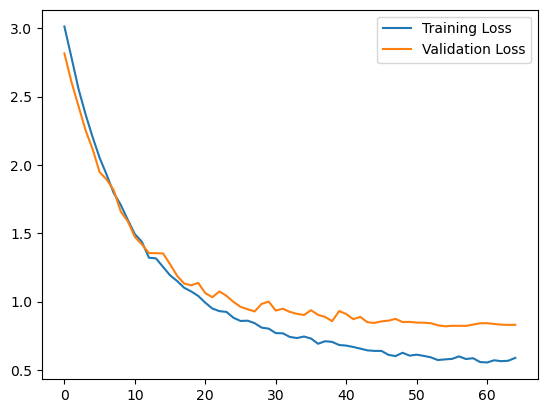

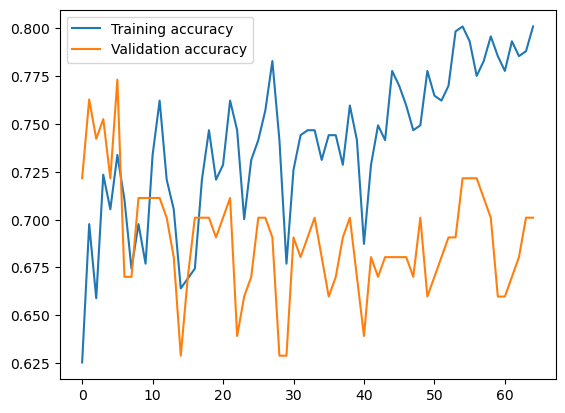

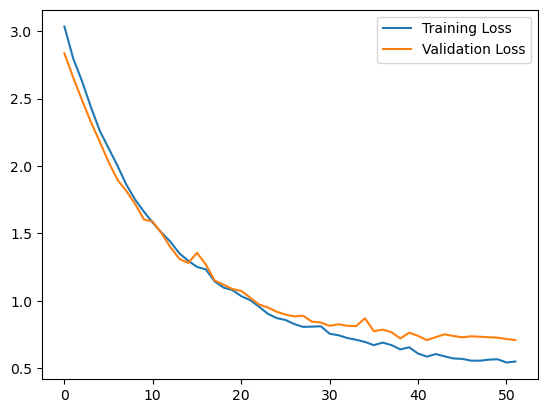

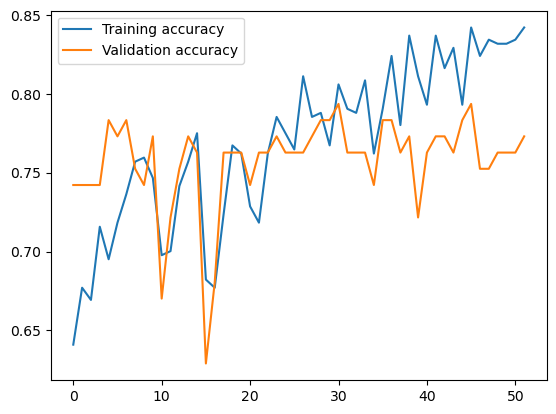

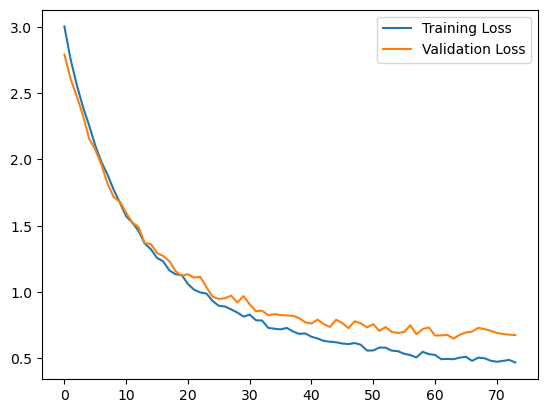

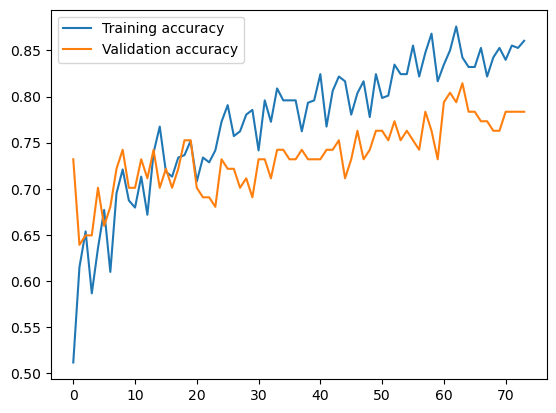

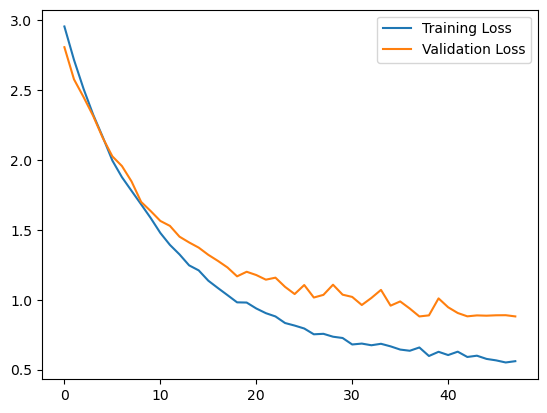

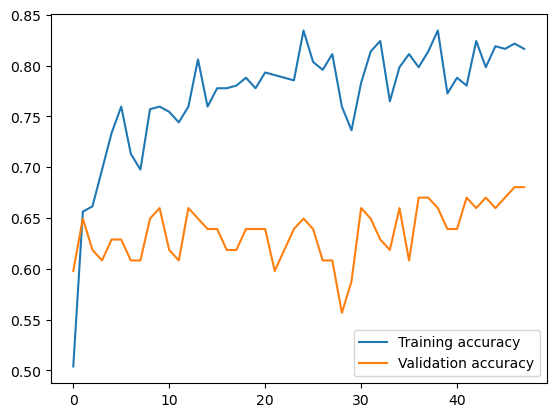

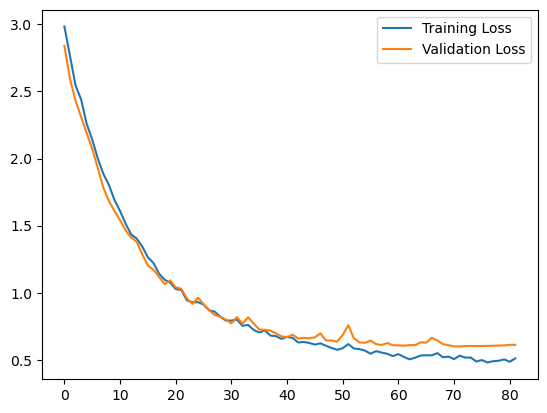

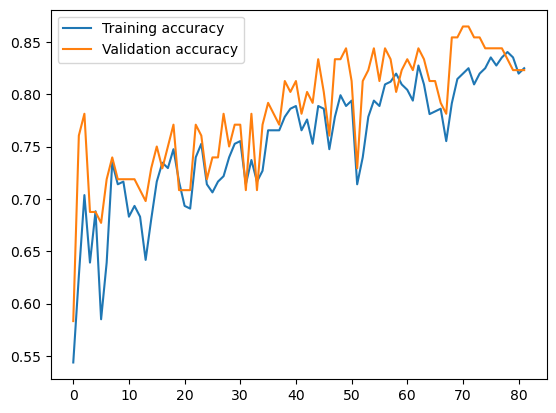

In [238]:
for i in history_dict.keys():
    history = history_dict[i].history
    loss = history['loss']
    val_loss = history['val_loss']
    plt.plot(loss, label = 'Training Loss')
    plt.plot(val_loss, label = 'Validation Loss')
    plt.legend()
    plt.show()
    
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    plt.plot(accuracy, label = 'Training accuracy')
    plt.plot(val_accuracy, label = 'Validation accuracy')
    plt.legend()
    plt.show()